In [1]:
from bs4 import BeautifulSoup
from IPython.core.display import display, HTML
import sqlite3
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
pd.set_option('display.max_colwidth', -1)
plt.rcdefaults()

In [3]:
conn = sqlite3.connect('../Data/crossvalidated.db')

In [4]:
# return all the records for questions posts from posts table
ques_query = "SELECT * FROM [posts]"

In [5]:
post_df = pd.read_sql_query(ques_query, conn)

In [6]:
post_df.shape

(151044, 21)

In [7]:
post_df.drop(['LastEditorDisplayName','CommunityOwnedDate','LastEditorUserId','LastEditDate',
             'LastActivityDate'],axis=1,inplace=True)

In [8]:
post_df.columns

Index([u'Body', u'ViewCount', u'ClosedDate', u'ParentID', u'CommentCount',
       u'AnswerCount', u'AcceptedAnswerId', u'Score', u'OwnerDisplayName',
       u'Title', u'PostTypeId', u'OwnerUserId', u'Tags', u'CreationDate',
       u'FavoriteCount', u'Id'],
      dtype='object')

#Helper functions

In [10]:
def makeplain(html):
    text = BeautifulSoup(html, 'html.parser').get_text()
    text = text.replace(u'\u200b','')
    text = text.replace(u'\xa0','')
    return text

In [11]:
post_df['Body_Text'] = post_df.apply(lambda row: makeplain(row['Body']), axis=1)

#Top Questions

In [18]:
top_100ques = post_df[(post_df.PostTypeId==1)].sort_values(['Score','ViewCount','AnswerCount','FavoriteCount','CommentCount'],\
                                      ascending=[False,False,False,False,False]).head(100)

In [13]:
top_100ques[['Score','Body_Text','Title','ViewCount','AnswerCount','FavoriteCount','CommentCount']].head()

,Score,Body_Text,Title,ViewCount,AnswerCount,FavoriteCount,CommentCount
2504,334,"In today's pattern recognition class my professor talked about PCA, eigenvectors & eigenvalues. \nI got the mathematics of it. If I'm asked to find eigenvalues etc. I'll do it correctly like a machine. But I didn't understand it. I didn't get the purpose of it. I didn't get the feel of it. I strongly believe in \n\nyou do not really understand something unless you can explain it to your grandmother -- Albert Einstein\n\nWell, I can't explain these concepts to a layman or grandma.\n\nWhy PCA, eigenvectors & eigenvalues? What was the need for these concepts?\nHow would you explain these to a layman?\n\n","Making sense of principal component analysis, eigenvectors & eigenvalues",134213.0,26.0,389.0,15
1489,272,"Lots of people use a main tool like Excel or another spreadsheet, SPSS, Stata, or R for their statistics needs. They might turn to some specific package for very special needs, but a lot of things can be done with a simple spreadsheet or a general stats package or stats programming environment.\nI've always liked Python as a programming language, and for simple needs, it's easy to write a short program that calculates what I need. Matplotlib allows me to plot it.\nHas anyone switched completely from, say R, to Python? R (or any other statistics package) has a lot of functionality specific to statistics, and it has data structures that allow you to think about the statistics you want to perform and less about the internal representation of your data. Python (or some other dynamic language) has the benefit of allowing me to program in a familiar, high-level language, and it lets me programmatically interact with real-world systems in which the data resides or from which I can take measurements. But I haven't found any Python package that would allow me to express things with ""statistical terminology"" – from simple descriptive statistics to more complicated multivariate methods.\nWhat can you recommend if I wanted to use Python as a ""statistics workbench"" to replace R, SPSS, etc.?\nWhat would I gain and lose, based on your experience?\n",Python as a statistics workbench,95622.0,25.0,328.0,1
5,226,"Last year, I read a blog post from Brendan O'Connor entitled ""Statistics vs. Machine Learning, fight!"" that discussed some of the differences between the two fields. Andrew Gelman responded favorably to this:\nSimon Blomberg: \n\nFrom R's fortunes\n package: To paraphrase provocatively,\n 'machine learning is statistics minus\n any checking of models and\n assumptions'.\n -- Brian D. Ripley (about the difference between machine learning\n and statistics) useR! 2004, Vienna\n (May 2004) :-) Season's Greetings!\n\nAndrew Gelman:\n\nIn that case, maybe we should get rid\n of checking of models and assumptions\n more often. Then maybe we'd be able to\n solve some of the problems that the\n machine learning people can solve but\n we can't!\n\nThere was also the ""Statistical Modeling: The Two Cultures"" paper by Leo Breiman in 2001 which argued that statisticians rely too heavily on data modeling, and that machine learning techniques are making progress by instead relying on the predictive accuracy of models.\nHas the statistics field changed over the last decade in response to these critiques? Do the two cultures still exist or has statistics grown to embrace machine learning techniques such as neural networks and support vector machines?\n",The Two Cultures: statistics vs. machine learning?,65657.0,17.0,211.0,6
398,217,This is one of my favorites:\n\nOne entry per answer. This is in the vein of the Stack Overflow question What’s your favorite “programmer” cartoon?.\nP.S. Do not hotlink the cartoon without the site's permission please.\n,"What is your favorite ""data analysis"" cartoon?",103708.0,68.0,196.0,10
108,208,"In the definition of standard deviation, why do we have to square the difference from the mean to get the mean (E) and take the squar

In [36]:
best_ques = top_100ques.Title.values

In [37]:
for ques in best_ques[:20]:
    display(HTML(ques)

#Top Answers

In [38]:
top_100ans = post_df[(post_df.PostTypeId==2)].sort(['Score'],ascending=[False]).head(100)

/usr/local/lib/python2.7/site-packages/IPython/kernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [39]:
top_100ans[['Score','Body_Text','Tags']].head()

Score  \
99888  259     
27635  251     
1525   231     
39438  225     
2512   220     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      

In [42]:
best_ans = top_100ans.Body.values
i=1
for ans in best_ans[:5]:
    print 'Top '+str(i)+ ' Answer'
    display(HTML(ans))
    print '------------------------------------------------------'
    i+=1   

Top 1 Answer


------------------------------------------------------
Top 2 Answer


------------------------------------------------------
Top 3 Answer


------------------------------------------------------
Top 4 Answer


------------------------------------------------------
Top 5 Answer


------------------------------------------------------


#Who's really contributing to the community?

In [43]:
%matplotlib inline
plt.rcParams.update({
    'figure.facecolor': 'white',
    'font.size': '24',
    'axes.grid': 'true',
})

In [53]:
# return all the records for questions posts from posts table
user_query = "SELECT DisplayName,Id FROM [users]"

In [54]:
user_df = pd.read_sql_query(user_query, conn)

In [55]:
user_df.shape

(78004, 2)

In [113]:
grouped = post_df[['OwnerUserId','DisplayName','ParentID','ClosedDate']].groupby(['OwnerUserId']).count()
grouped.reset_index(inplace=True)
top_users = grouped.merge(user_df, left_on=grouped.OwnerUserId,right_on=user_df.Id,suffixes=['_post', '_user'])
top_users.rename(columns={'DisplayName_post':'PostCount',\
                          'ParentID':'AnsCnt','ClosedDate':'BadQuesCnt'},inplace=True)
top_users['QuesCnt'] = top_users['PostCount'] - top_users['AnsCnt']

In [114]:
top_users.head()

,OwnerUserId,PostCount,AnsCnt,BadQuesCnt,DisplayName_user,Id,QuesCnt
0,-1.0,300,0,0,Community,-1,300
1,5.0,117,100,1,Shane,5,17
2,6.0,12,6,0,Harlan,6,6
3,7.0,2,1,0,Vince,7,1
4,8.0,121,109,0,csgillespie,8,12


In [115]:
top_10user = top_users.sort_values(['PostCount','AnsCnt'],ascending=[False,False]).head(10)
top_10user.set_index('DisplayName_user',inplace=True)

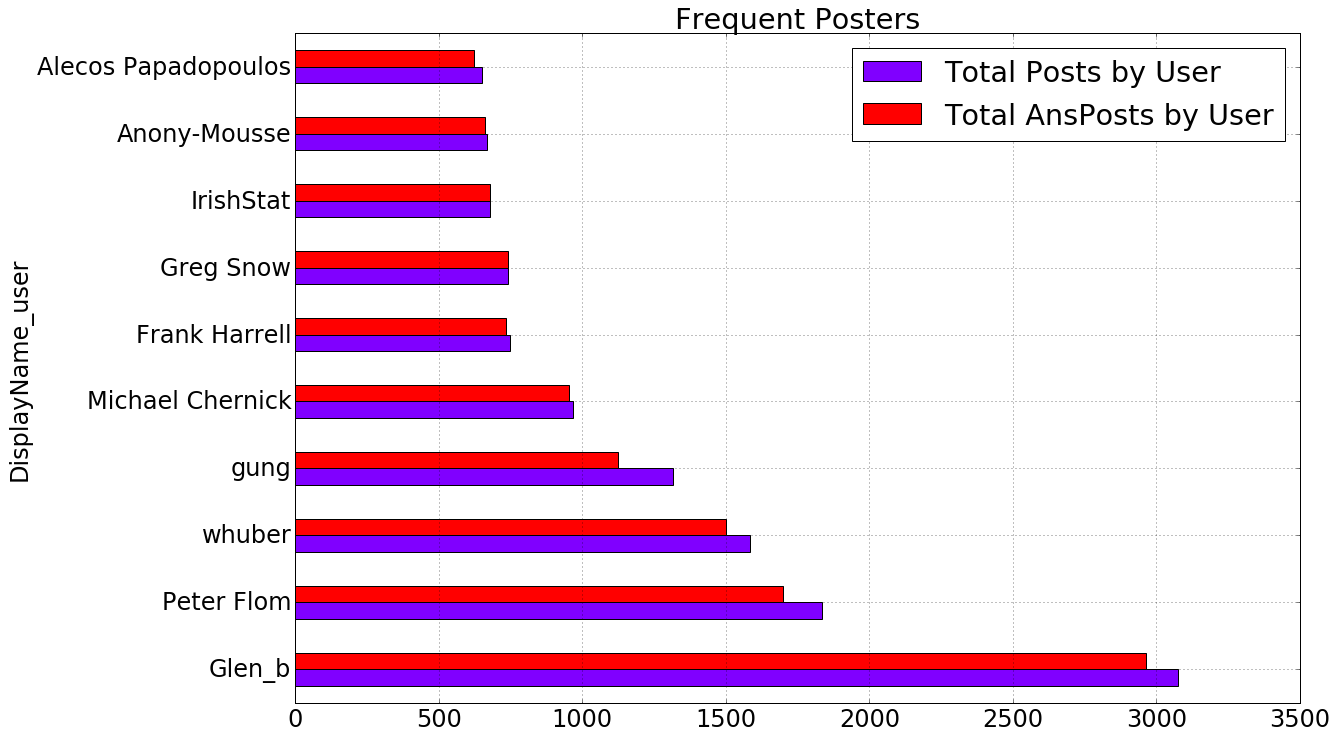

In [116]:
top_10user[['PostCount','AnsCnt']].plot(kind='barh', title='Frequent Posters', figsize=(18, 12), colormap='rainbow')
plt.legend(['Total Posts by User', 'Total AnsPosts by User'])

### Frequent Posters = Good Users? 

In [117]:
top_10badusers = top_users.sort_values(['BadQuesCnt','QuesCnt'],ascending=[False,False]).head(10)
top_10badusers.set_index('DisplayName_user',inplace=True)

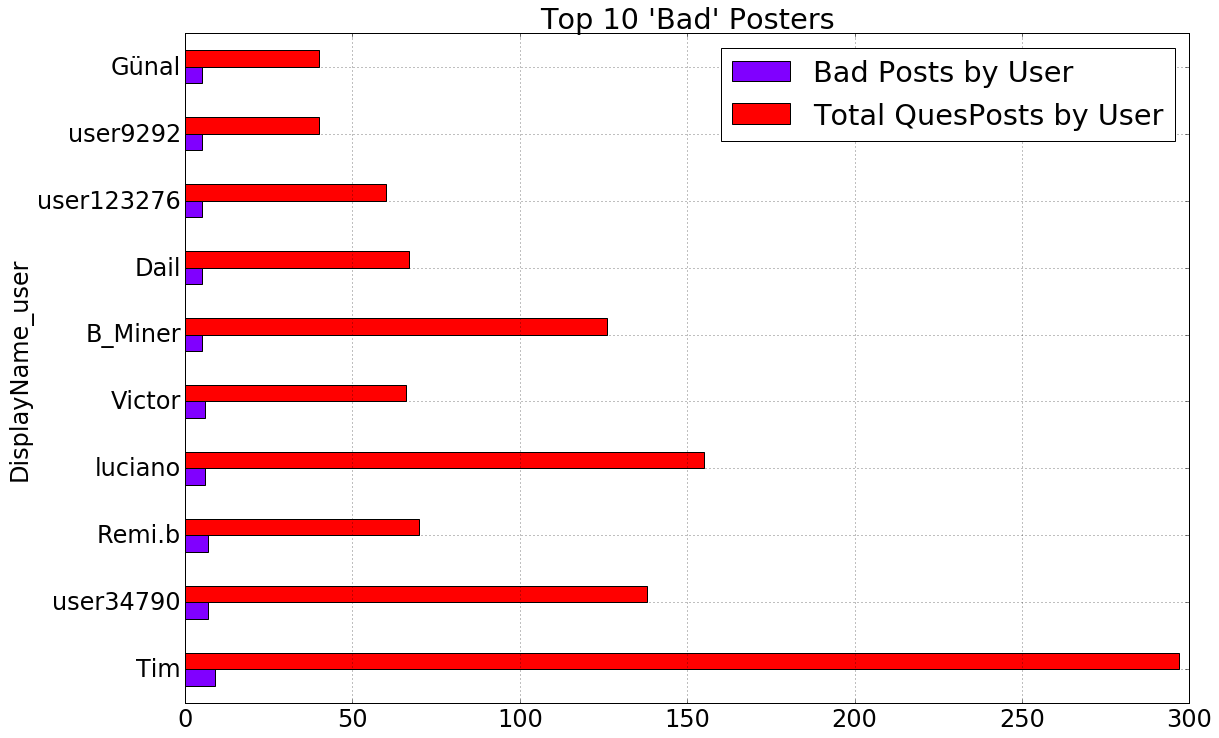

In [118]:
top_10badusers[['BadQuesCnt','QuesCnt']].plot(kind='barh', title="Top 10 'Bad' Posters", figsize=(18, 12), colormap='rainbow')
plt.legend(['Bad Posts by User', 'Total QuesPosts by User'])

In [121]:
best_answer_ids = post_df.AcceptedAnswerId.dropna().values
best_answers_df = post_df[post_df.Id_post.isin(best_answer_ids)]

In [122]:
best_answers_df.shape

(23441, 19)

In [129]:
tmp = best_answers_df[['OwnerUserId','Id_post']].groupby('OwnerUserId').count()
tmp.reset_index(inplace=True)
top_answers = tmp.merge(user_df, left_on=tmp.OwnerUserId,right_on=user_df.Id,suffixes=['_post', '_user'])
top_answers.rename(columns={'Id_post':'AccpetedAnsCount'},inplace=True)

In [130]:
top_answers.head()

,OwnerUserId,AccpetedAnsCount,DisplayName,Id
0,5.0,32,Shane,5
1,6.0,2,Harlan,6
2,8.0,30,csgillespie,8
3,22.0,5,radek,22
4,23.0,1,Jay Stevens,23


In [133]:
top_answerers = top_answers.merge(top_users[['AnsCnt','PostCount','OwnerUserId']],left_on=tmp.OwnerUserId,\
                                  right_on=top_users[['AnsCnt','PostCount','OwnerUserId']].OwnerUserId,\
                                  suffixes=['_ans', '_users'])
top_10answerers = top_answerers.sort_values(['AccpetedAnsCount','AnsCnt'],ascending=[False,False]).head(10)
top_10answerers.set_index('DisplayName',inplace=True)

In [143]:
top_answerers.head()

,OwnerUserId_ans,AccpetedAnsCount,DisplayName,Id,AnsCnt,PostCount,OwnerUserId_users
0,5.0,32,Shane,5,100,117,5.0
1,6.0,2,Harlan,6,6,12,6.0
2,8.0,30,csgillespie,8,109,121,8.0
3,22.0,5,radek,22,29,45,22.0
4,23.0,1,Jay Stevens,23,2,3,23.0


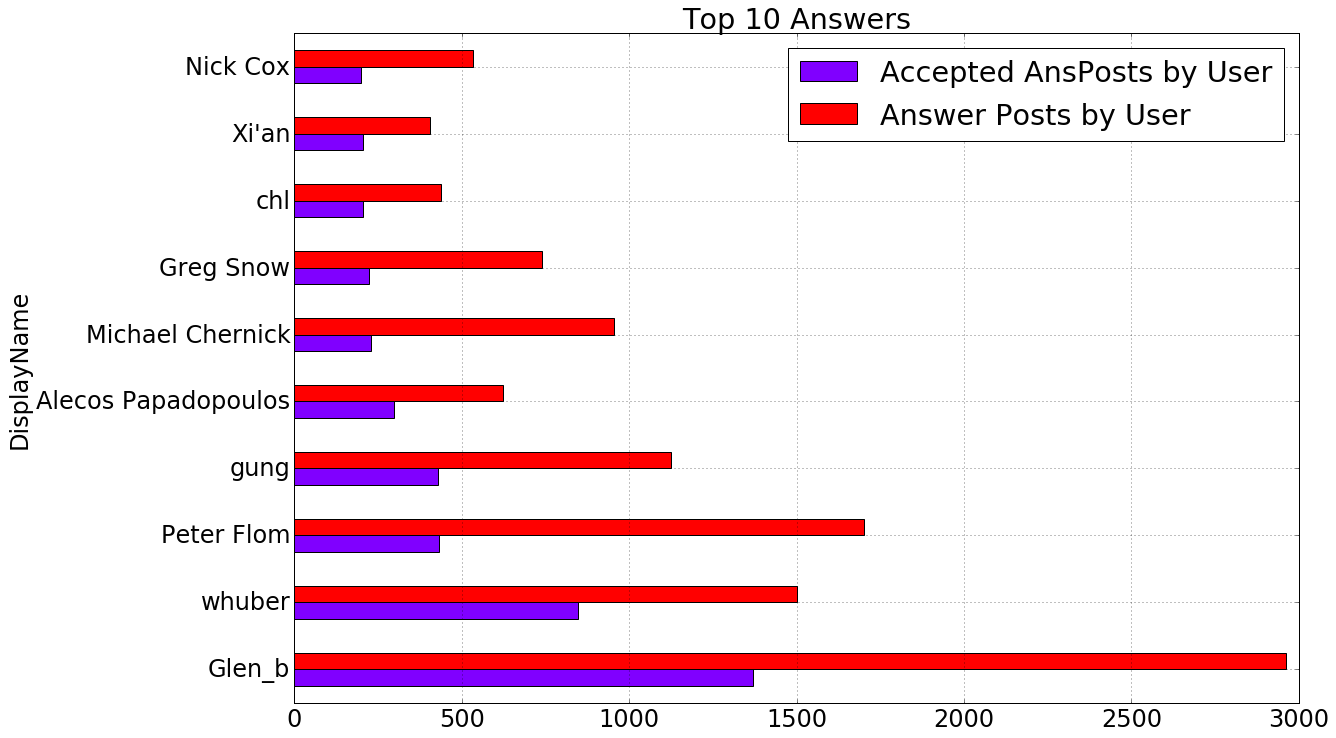

In [138]:
top_10answerers[['AccpetedAnsCount','AnsCnt']].plot(kind='barh', title="Top 10 Answers", figsize=(18, 12), colormap='rainbow')
plt.legend(['Accepted AnsPosts by User','Answer Posts by User'])

#Word cloud for Posts

In [16]:
import pickle
with open('../Data/stop_words.pickle', 'rb') as handle:
  stop_words = pickle.load(handle)

In [45]:
from nltk.tokenize import word_tokenize
from textblob import TextBlob, Word
import re
import string

In [42]:
verb_exp = set(['VB', 'VBZ', 'VBP', 'VBD','VBN','VBG'])
#porter_stemmer = PorterStemmer()
def clean_text(row):
    soup = BeautifulSoup(row, 'html.parser')
    #remove code
    for tag in soup.find_all('code'):
        tag.replaceWith(' ')
        
    raw = soup.get_text().lower()
    #remove link
    raw_no_link = re.sub('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+', '', raw)
    #remove email
    no_link_email = re.sub(r'[\w\.-]+@[\w\.-]+[\.][com|org|ch|uk]{2,3}', "", raw_no_link)
    #remove whitespace
    tab_text = '\t\n\r\x0b\x0c'
    no_link_email_space = "".join([ch for ch in no_link_email if ch not in set(tab_text)])
    #remove fomula
    reg = '(\$.+?\$)|((\\\\begin\{.+?\})(.+?)(\\\\end\{(.+?)\}))'
    raw = re.sub(reg, "", no_link_email_space, flags=re.IGNORECASE)   
    #remove numbers
    raw = re.sub('[0-9]+?', ' ', raw) 
    # remove punctuation
    regex = re.compile('[%s]' % re.escape(string.punctuation))
    raw = regex.sub(' ', raw)
    #clean out the characters left out after the above step, like we’re, I’m, It’s, i.e., isn't
    raw = re.sub('( s )|( re )|( m )|( i e )|(n t )',' ',raw) 
    
    # lementize
    row_t = TextBlob(raw)
    raw = []
    for word, pos in row_t.tags:
        if pos in verb_exp:
            word = Word(word)
            word = word.lemmatize("v")
        else:
            word = Word(word)
            word = word.lemmatize()
        raw.append(word)
    clean = ' '.join(raw)   
    
    # remove stop words
    cleaned_text = " ".join([word for word in word_tokenize(clean) if word not in stop_words]) 
     
    return(cleaned_text)

In [43]:
top_100ques.Body[2504]

u"<p>In today's pattern recognition class my professor talked about PCA, eigenvectors &amp; eigenvalues. </p>\n\n<p>I got the mathematics of it. If I'm asked to find eigenvalues etc. I'll do it correctly like a machine. But I didn't <strong>understand</strong> it. I didn't get the purpose of it. I didn't get the feel of it.  I strongly believe in </p>\n\n<blockquote>\n  <p>you do not really understand something unless you can explain it to your grandmother -- Albert Einstein</p>\n</blockquote>\n\n<p>Well, I can't explain these concepts to a layman or grandma.</p>\n\n<ol>\n<li>Why PCA, eigenvectors &amp; eigenvalues? What was the <em>need</em> for these concepts?</li>\n<li>How would you explain these to a layman?</li>\n</ol>\n"

In [46]:
clean_text(top_100ques.Body[2504])

u'today pattern recognition class professor talk pca eigenvectors eigenvalues mathematics eigenvalue correctly machine understand purpose feel strongly understand explain grandmother albert einsteinwell explain concept layman grandma pca eigenvectors eigenvalues concept explain layman'

In [47]:
text_bodies = post_df.Body.map(lambda i: clean_text(i))

In [8]:
from spacy.en import English
from gensim import corpora, models, similarities

In [9]:
nlp = English()